# Deduplication Problem by Content Square

## Problem statement
Movies are collected from different data providers. Data providers don't always use the same information to describe the same movie.
Given a list of movies where each movie is described by two different providers, the task is to identify the duplications.

The purpose of this kernel is first to explore the dataset, then, try to identify duplicated records.

## What is duplication?
In our case, duplicate means we can have two slightly different entries for the same movie. This is what is called in academic studies __record linkage__. Record linkage is an heavy research field with a lot of potential, with a lot of possible ways to solve them (machine learning, probabilistic, deterministic and so on).

To solve our problem, we will use the probabilistic approch.

## Reminder
For two entries describing the same movie, it's possible to have the following differences:
* id: each is unique
* year: ±1 year at maximum
* length: ±5% more, 2* |x-y| / (x+y) <= 0.05 where x and y is the provided movie length
* \[genre, actors, directors\]: different order, or missing one or many

## Setup Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Seaborn: {sns.__version__}")

Pandas: 1.2.4
Numpy: 1.20.1
Seaborn: 0.11.1


<Figure size 1152x432 with 0 Axes>

## Read the dataset

In [2]:
df = pd.read_csv('movies.tsv', sep='\t', low_memory=False) # low_memory avoid reading by chunks and mixed types issues
df = df.replace(r'\N', np.NaN) # Unknown fields are marked \N
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558458 entries, 0 to 558457
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         558458 non-null  object
 1   year       558458 non-null  int64 
 2   length     558458 non-null  int64 
 3   genre      483540 non-null  object
 4   directors  461089 non-null  object
 5   actors     415669 non-null  object
dtypes: int64(2), object(4)
memory usage: 25.6+ MB


In [3]:
df.head()

,id,year,length,genre,directors,actors
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."
1,7e0a9d8e-99b7-4a88-b610-3a52faaae2c1,1929,64,"Crime,Drama,Mystery",Phil Rosen,"Ricardo Cortez,Nancy Welford"
2,6acef12b-404c-4a8f-b365-cef798585893,1993,87,Thriller,Christian González,"Leonardo Daniel,Roberto 'Flaco' Guzmán,Armando..."
3,9e41e9a6-5628-4123-9353-b9487654ed84,2011,46,"Biography,Documentary,Drama",Han Tang,NaN
4,8b2789fe-36fc-4f74-9094-b11ec46bfd42,2018,60,Documentary,NaN,NaN


In [4]:
df.describe()

,year,length
count,558458.000000,558458.000000
mean,1992.097026,87.525569
std,25.832787,53.825148
min,1893.000000,1.000000
25%,1976.000000,73.000000
50%,2004.000000,88.000000
75%,2013.000000,99.000000
max,2026.000000,14400.000000


Out of 558 458 entries, only genre, directors and actors contains null values and need to be processed.

Year and length does not look bad, a majority are those values make sense, and can probably be used as a blocking key to generate meaningful pairs.

## Data cleaning

In [4]:
def split_list(x):
    return x if isinstance(x, float) else set(x.split(','))

df['actors_split'] = df['actors'].apply(split_list)
df['genre'] = df['genre'].apply(split_list)
df['directors'] = df['directors'].apply(split_list)

df.head()

,id,year,length,genre,directors,actors,actors_split
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,{Stephen Ang},"Stephen Ang,George Capacete,Kimberly Cashner,P...","{George Capacete, Kimberly Cashner, Peggy Glen..."
1,7e0a9d8e-99b7-4a88-b610-3a52faaae2c1,1929,64,"{Mystery, Crime, Drama}",{Phil Rosen},"Ricardo Cortez,Nancy Welford","{Ricardo Cortez, Nancy Welford}"
2,6acef12b-404c-4a8f-b365-cef798585893,1993,87,{Thriller},{Christian González},"Leonardo Daniel,Roberto 'Flaco' Guzmán,Armando...","{Leonardo Daniel, Roberto 'Flaco' Guzmán, Arma..."
3,9e41e9a6-5628-4123-9353-b9487654ed84,2011,46,"{Documentary, Drama, Biography}",{Han Tang},NaN,NaN
4,8b2789fe-36fc-4f74-9094-b11ec46bfd42,2018,60,{Documentary},NaN,NaN,NaN


## Visualization

It is time to visualize the repartition of null values accross our dataset:

<AxesSubplot:>

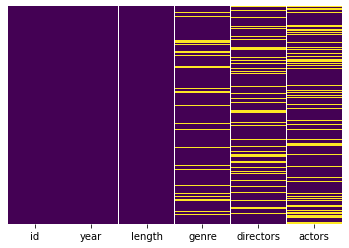

In [17]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [18]:
null_actors = df[df['actors'].isna()]
null_actors_percentage = len(null_actors)*100/len(df['actors'])

null_directors = df[df['directors'].isna()]
null_directors_percentage = len(null_directors)*100/len(df['directors'])

print("NaN actors values: {} ({:.2f}%)".format(len(null_actors), null_actors_percentage))
print("NaN directors values: {} ({:.2f}%)".format(len(null_directors), null_directors_percentage))

NaN actors values: 142789 (25.57%)
NaN directors values: 97369 (17.44%)


As expected, genre, directors and actors has null values. However, we can clearly see that genre has less null value than directors or actors and the lack of data is to big in order to try to infer.

That may indicate genre will certainly has more weight, then directors and finally actors in the similarity function.

### Year
I suggested year would be a good candidate as a blocking key. How is the repartition?

<AxesSubplot:xlabel='year'>

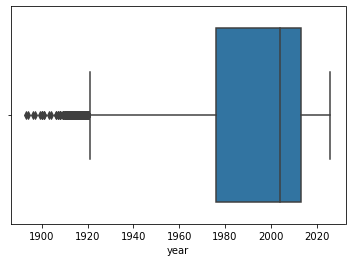

In [19]:
sns.boxplot(data=df, x='year')

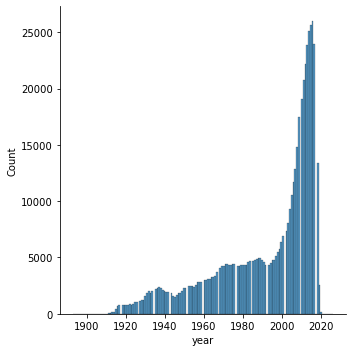

In [20]:
sns.displot(data=df, x='year')

In [21]:
df['year'].nunique()

129

### Length

<AxesSubplot:xlabel='length'>

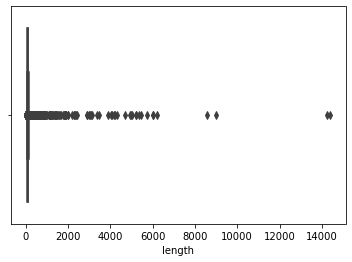

In [22]:
sns.boxplot(data=df, x='length')

In [23]:
df['length'].nunique()

563

### Genre
Analyze genre occurences for columns in list format.

In [68]:
from collections import defaultdict

def count_list_values(serie):
    d = defaultdict(int)
    for e in serie:
        if not isinstance(e, float):
            for v in e:
                d[v] += 1
            
    return dict(d)

genres_occ = count_list_values(df['genre'])
print(f'Number of genre: {len(genres_occ.keys())}')

Number of genre: 28


<AxesSubplot:>

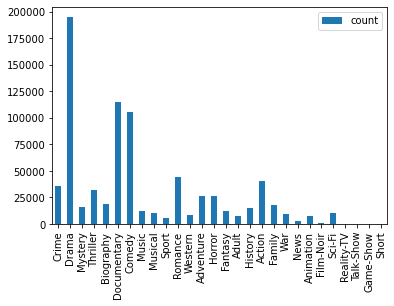

In [69]:
genres = pd.DataFrame.from_dict(genres_occ, orient='index', columns=['count'])
genres.plot(kind='bar')

### Directors

In [70]:
directors_occ = count_list_values(df['directors'])
directors = pd.DataFrame.from_dict(directors_occ, orient='index', columns=['count'])

print(f'Number of directors: {len(directors_occ.keys())}')

Number of directors: 130533


## Solution
We want to avoid comparing all records against eachother, that would require N*(N-1)/2. For our use case, that represent more than 15B comparison, any sane person knows that a quadratric algorithm is not suitable. We need to cut the search space first, and we have a lot way to do that.

### Indexing
 

In [6]:
import recordlinkage as rl

indexer = rl.BlockIndex('actors')
pairs = indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} paris")

Full index: 558458 records, 126111 paris


In [75]:
pairs.to_frame()[:10].values

array([[517912,      0],
       [289677,      6],
       [238739,      8],
       [477767,      9],
       [538498,     12],
       [ 76008,     20],
       [120367,     20],
       [120367,  76008],
       [244771,     20],
       [244771,  76008]], dtype=int64)

In [37]:
df.iloc[477767].actors

'Erol Günaydin,Yilmaz Güney,Müjgan Agrali,Yildirim Gencer,Ali Sen,Hüseyin Peyda'

In [38]:
df.iloc[9].actors

'Erol Günaydin,Yilmaz Güney,Müjgan Agrali,Yildirim Gencer,Ali Sen,Hüseyin Peyda'

In [9]:
vectorized_expr = np.vectorize(lambda x, y: 1.0 if 2*abs(x-y)/(x+y) <= 0.05 else 0.0)
jaccard_vec = np.vectorize(lambda x, y: 0.0 if (isinstance(x, float) or isinstance(y, float)) else float(len(x.intersection(y)) / len(x.union(y))))

def length_similarity(s1, s2):
    return vectorized_expr(s1, s2)

def jaccard_similarity(s1, s2):
    return jaccard_vec(s1, s2)

comp = rl.Compare()
comp.numeric('year', 'year', method='step', offset=1, label='year') # Step: expr = 'abs(d - origin) <= offset'
comp.compare_vectorized(length_similarity, 'length', 'length', label='length')
comp.compare_vectorized(jaccard_similarity, 'genre', 'genre', label='genre')
comp.compare_vectorized(jaccard_similarity, 'directors', 'directors', label='directors')
comp.compare_vectorized(jaccard_similarity, 'actors_split', 'actors_split', label='actors')

comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head()

,,year,length,genre,directors,actors
517912,0,1.0,1.0,0.000000,1.0,1.0
289677,6,1.0,1.0,0.333333,0.0,1.0
238739,8,1.0,1.0,0.000000,1.0,1.0
477767,9,1.0,1.0,0.000000,1.0,1.0
538498,12,1.0,1.0,1.000000,1.0,1.0


In [10]:
scores = np.average(comparison_vectors.values, axis=1, weights=[30, 30, 10, 15, 15])
scores_comparison_vectors = comparison_vectors.assign(score=scores)
scores_comparison_vectors.head()

,,year,length,genre,directors,actors,score
517912,0,1.0,1.0,0.000000,1.0,1.0,0.900000
289677,6,1.0,1.0,0.333333,0.0,1.0,0.783333
238739,8,1.0,1.0,0.000000,1.0,1.0,0.900000
477767,9,1.0,1.0,0.000000,1.0,1.0,0.900000
538498,12,1.0,1.0,1.000000,1.0,1.0,1.000000


In [15]:
matches = comparison_vectors[scores_comparison_vectors['score'] >= 0.75]
matches.head()

,,year,length,genre,directors,actors
517912,0,1.0,1.0,0.000000,1.0,1.0
289677,6,1.0,1.0,0.333333,0.0,1.0
238739,8,1.0,1.0,0.000000,1.0,1.0
477767,9,1.0,1.0,0.000000,1.0,1.0
538498,12,1.0,1.0,1.000000,1.0,1.0


In [16]:
matches.shape

(103370, 5)

In [11]:
display(df.loc[[517912]])
print("matched:")
display(df.loc[matches.loc[(517912,)].index])

,id,year,length,genre,directors,actors
517912,f0b43346-24f2-477b-9e0b-0c41e62ac7e3,2016,60,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."


matched:


<ipython-input-11-b07b460e1dc8>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  display(df.loc[matches.loc[(517912,)].index])


,id,year,length,genre,directors,actors
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."


In [124]:
with open('result.tsv', 'w') as f:
    for index, row in matches.iterrows():
        f.write(f"{df.iloc[index[0]]['id']}\t {df.iloc[index[1]]['id']}\n")